In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [2]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [3]:
from src.ksd.kernel import median_heuristic, l2norm
from src.ksd.models import create_mixture_gaussian

In [4]:
dim = 5
n = 500

# Oracle choice of variance

In [55]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

In [56]:
var = 5.
convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

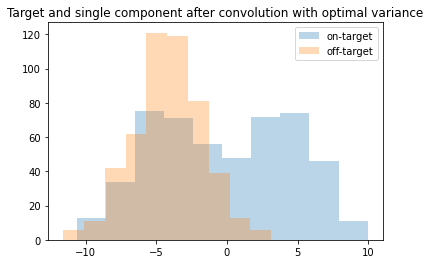

In [58]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution with optimal variance")

# Med heuristic

In [92]:
med_ls = []
delta_ls = np.linspace(1., 10, 100)
for delta in tqdm(delta_ls):
    target = create_mixture_gaussian(dim=dim, delta=delta)
    samples = target.sample(500)
    l2norm_mat = l2norm(samples, tf.identity(samples))
    med_ls.append(median_heuristic(l2norm_mat) / dim)
    

  0%|          | 0/100 [00:00<?, ?it/s]

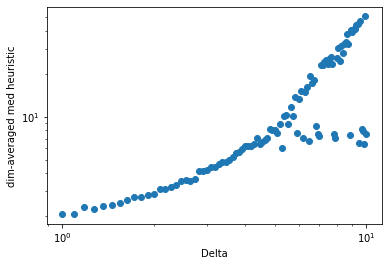

In [93]:
plt.scatter(delta_ls, med_ls)
plt.xscale("log")
plt.yscale("log")
_ = plt.xlabel("Delta")
_ = plt.ylabel("dim-averaged med heuristic")

In [94]:
delta = delta_ls[33]
var = med_ls[33].numpy()

In [95]:
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

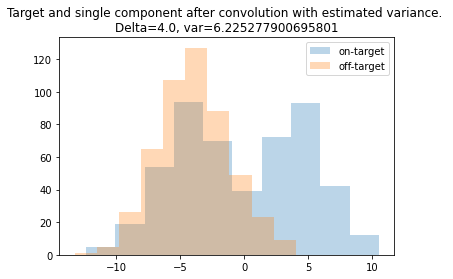

In [96]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title(f"Target and single component after convolution with estimated variance. \nDelta={delta}, var={var}")

In [97]:
# analyze robustness 
med_ls = []
nrep = 500
for _ in trange(nrep):
    target = create_mixture_gaussian(dim=dim, delta=delta)
    samples = target.sample(500)
    l2norm_mat = l2norm(samples, tf.identity(samples))
    med_val = median_heuristic(l2norm_mat).numpy() / dim
    med_ls.append(med_val)


  0%|          | 0/500 [00:00<?, ?it/s]

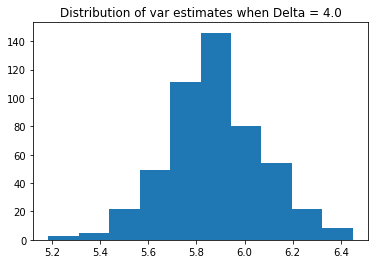

In [101]:
_ = plt.hist(med_ls)
_ = plt.title(f"Distribution of var estimates when Delta = {delta}")

# Pairwise difference as noise distribution

In [6]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)
    
samples_on = target.sample(500)
samples_off = target_off.sample(500)

2021-12-02 09:18:47.812445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 09:18:48.381654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


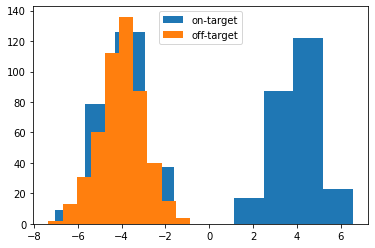

In [7]:
_ = plt.hist(samples_on.numpy()[:, 0], label="on-target")
_ = plt.hist(samples_off.numpy()[:, 0], label="off-target")
plt.legend()

In [8]:
tf.random.set_seed(0)

In [18]:
pair_diff = tf.expand_dims(samples_on, axis=0) - tf.expand_dims(samples_on, axis=1) # n x n x dim
noise_samples = tf.reshape(pair_diff, shape=(-1, dim))

In [46]:
rm_ind = [i*(n+1) for i in range(n)]
ind = [i for i in range(noise_samples.shape[0]) if i not in rm_ind]

In [50]:
noise_samples = tf.gather(noise_samples, ind)

In [19]:
noise_dist = tfp.distributions.Empirical(noise_samples, event_ndims=1)

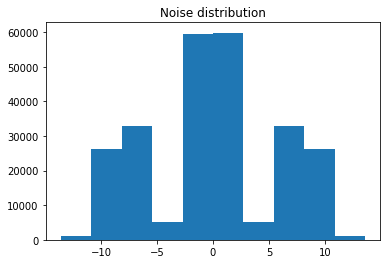

In [49]:
_ = plt.hist(noise_samples.numpy()[:, 0])
_ = plt.title("Noise distribution")

$$
\prod_{i=1}^{\min(2, d)} \left[ \frac{1}{a_i} (e^{a_i \min(1, u_i)} - 1) \right]
\prod_{i > 2} \left[ \frac{1}{a_i} (e^{a_i} - 1) \right]
$$

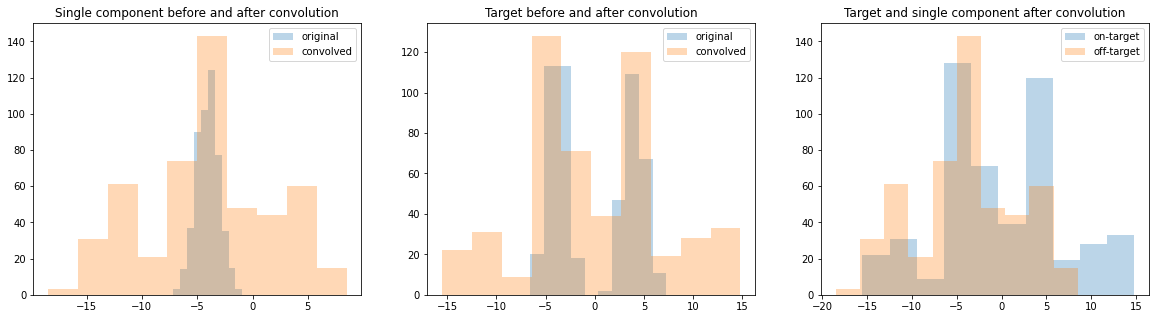

In [53]:
xx = noise_dist.sample(500)
samples_off_convolved = samples_off + xx

plt.figure(figsize=(20, 5))
plt.subplot(131)
_ = plt.hist(samples_off.numpy()[:, 0], label="original", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="convolved", alpha=0.3)
_ = plt.legend()
_ = plt.title("Single component before and after convolution")

plt.subplot(132)
samples_on_convolved = samples_on + xx
_ = plt.hist(samples_on.numpy()[:, 0], label="original", alpha=0.3)
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="convolved", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target before and after convolution")

plt.subplot(133)
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution")


# Optimization

In [68]:
from src.ksd.ksd import ConvolvedKSD

In [69]:
tf.random.set_seed(0)

In [70]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)
    
samples_on = target.sample(500)
samples_off = target_off.sample(500)

In [71]:
num_est = 10000
convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))
conv_samples_full = convolution.sample(num_est) # for p

conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
conv_samples = tf.gather(conv_samples_full, conv_ind, axis=0) # for q

In [72]:
imq = IMQ(med_heuristic=True)

In [73]:
ksd = ConvolvedKSD(target=target, kernel=imq, conv_kernel=None)

In [74]:
log_noise_std = 3.
# log_noise_std = log_sigma.numpy()

# reparametrized
ksd_val1 = ksd.eval(log_noise_std=log_noise_std,
         X=samples_off, 
         Y=tf.identity(samples_off),
         conv_samples_full=conv_samples_full,
         conv_samples=conv_samples,
)

# original
ksd_val2 = ksd(X=samples_off + tf.exp(log_noise_std) * conv_samples,
    Y=tf.identity(samples_off + tf.exp(log_noise_std) * conv_samples),
    conv_samples=tf.exp(log_noise_std) * conv_samples_full
)

In [75]:
tf.experimental.numpy.allclose(ksd_val1, ksd_val2)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [77]:
# log_sigma = tf.Variable(tf.math.log(3.))
log_sigma = tf.Variable(1.)

# with off-target samples
loss_fn = lambda: -ksd.eval(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)

losses = tfp.math.minimize(loss_fn,
                           num_steps=100,
                           optimizer=tf.optimizers.Adam(learning_rate=0.1))

print(-losses)
print("best var", tf.exp(log_sigma).numpy()**2)

tf.Tensor(
[0.00891369 0.00885993 0.00894283 0.00894278 0.00891491 0.00893367
 0.00895658 0.00894777 0.00893947 0.00894551 0.00895614 0.00895346
 0.00894341 0.00894741 0.0089562  0.0089549  0.00894974 0.00894612
 0.00895349 0.00895656 0.00895227 0.0089518  0.00895518 0.0089568
 0.00895352 0.00894491 0.00894812 0.00895309 0.00895635 0.0089568
 0.00895655 0.0089561  0.00895624 0.00895615 0.00895677 0.00895681
 0.00895681 0.00895665 0.00895622 0.0089556  0.00895492 0.00895426
 0.00895438 0.00895662 0.00895608 0.00895461 0.00895582 0.0089566
 0.00895677 0.00895679 0.00895649 0.00895509 0.00895566 0.0089566
 0.00895153 0.00895086 0.00895635 0.00895642 0.00895478 0.00895444
 0.00895678 0.00895598 0.00895574 0.00895507 0.00895588 0.00895677
 0.00895548 0.00895589 0.00895665 0.00895675 0.00895584 0.00894895
 0.00895173 0.00895677 0.00895613 0.0089554  0.00895566 0.00895656
 0.00895562 0.00895611 0.00895677 0.00895675 0.00895661 0.00895658
 0.00895658 0.00895662 0.00895649 0.00895529 0.00895664

In [16]:
# with on-target samples
loss_fn = lambda: -ksd.eval(log_sigma, samples_on, tf.identity(samples_on), conv_samples_full, conv_samples)

losses = tfp.math.minimize(loss_fn,
                           num_steps=100,
                           optimizer=tf.optimizers.Adam(learning_rate=0.1))

print(-losses)
print("best var", tf.exp(log_sigma).numpy()**2)

tf.Tensor(
[0.01770007 0.01770013 0.01770001 0.01770013 0.01770011 0.01770009
 0.01770009 0.01770009 0.01770012 0.01770014 0.01770011 0.0177001
 0.01770013 0.01770012 0.0177001  0.01770008 0.01770009 0.01770009
 0.01770011 0.01770013 0.01770014 0.01770007 0.01770011 0.01770013
 0.01770012 0.01770011 0.0177001  0.0177001  0.01770012 0.01770012
 0.01770014 0.01770009 0.01770008 0.01770014 0.01770012 0.01770011
 0.0177001  0.01770011 0.01770012 0.01770012 0.01770014 0.01770012
 0.01770012 0.01770013 0.01770012 0.01770011 0.0177001  0.01770009
 0.0177001  0.01770011 0.01770012 0.01770013 0.01770012 0.01770013
 0.01770014 0.01770014 0.01770013 0.01770012 0.01770014 0.01770014
 0.01770014 0.01770013 0.01770013 0.01770014 0.01770015 0.01770013
 0.01770015 0.01770012 0.01770011 0.01770011 0.01770011 0.01770011
 0.01770014 0.01770013 0.01770012 0.01770013 0.01770013 0.01770012
 0.01770012 0.01770014 0.01770012 0.01770012 0.01770013 0.01770012
 0.01770012 0.01770012 0.01770012 0.01770014 0.01770

In [37]:
# optimizing the difference
def loss_fn():
    res = -(
        ksd.eval(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
        - ksd.eval(log_sigma, samples_on, tf.identity(samples_on), conv_samples_full, conv_samples)
    )
    return res

losses = tfp.math.minimize(loss_fn,
                           num_steps=100,
                           optimizer=tf.optimizers.Adam(learning_rate=0.1))

print(-losses)
print("best var", tf.exp(log_sigma).numpy()**2)

tf.Tensor(
[0.00679092 0.00672381 0.00682133 0.00685612 0.00680116 0.0067933
 0.00684238 0.00685894 0.00682372 0.00681328 0.0068452  0.00686153
 0.00684379 0.00682539 0.00683365 0.0068552  0.0068606  0.00684764
 0.0068397  0.00684907 0.00686035 0.00685942 0.00684959 0.00684737
 0.00685618 0.00686148 0.0068585  0.00685458 0.00685725 0.00686054
 0.00686152 0.00685973 0.00685813 0.00686036 0.0068615  0.00685999
 0.00686042 0.00686145 0.0068615  0.00686153 0.00686101 0.00686049
 0.00686151 0.00686142 0.00686072 0.00686132 0.00686136 0.00686071
 0.00686137 0.00686095 0.00686031 0.0068585  0.00686037 0.0068615
 0.00685889 0.00685917 0.00686005 0.00686145 0.00686151 0.00686132
 0.00686112 0.00686133 0.00686149 0.00686143 0.00686116 0.00686124
 0.00686116 0.006861   0.00686086 0.00686149 0.00686054 0.00686029
 0.00686134 0.00686134 0.0068615  0.0068615  0.00686079 0.00686109
 0.00686151 0.00686145 0.00685913 0.00686088 0.00686077 0.00685618
 0.00685766 0.00686078 0.00686144 0.00686087 0.006861

## Convolved KSD as a function of log std

In [16]:
from src.ksd.ksd import ConvolvedKSD
tf.random.set_seed(0)

In [17]:
delta = 4.
n = 500
num_est = 10000

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))

kernel = IMQ(med_heuristic=True)

ksd = ConvolvedKSD(target=target, kernel=kernel, conv_kernel=None)

std_list = [0.01, 0.05, 0.1, 0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 
            20., 30., 50., 70., 100., 250., 500., 750., 1e3]

In [18]:

# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)


In [19]:
ksd_df = pd.DataFrame(columns=["n", "ksd", "std", "seed", "type"])

for std in tqdm(std_list):
    for seed in range(10):
            # convolution sample
            conv_sample_full = convolution.sample(num_est) # for p

            conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
            conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

#             # off-target sample
#             off_sample = proposal_off.sample(n)

            log_noise_std = tf.math.log(std)

            ksd_val_off = ksd.eval(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_off, np.exp(log_noise_std), seed, "off-target"]

#             # on-target sample
#             on_sample = proposal_on.sample(n)

            log_noise_std_on = log_noise_std
            ksd_val_on = ksd.eval(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_on, np.exp(log_noise_std_on), seed, "target"]


  0%|          | 0/23 [00:00<?, ?it/s]

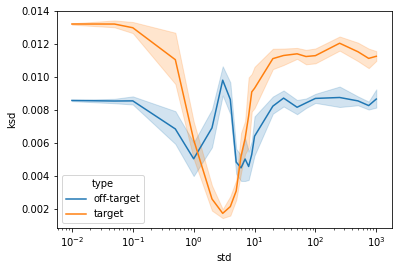

In [20]:
sns.lineplot(data=ksd_df, x="std", y="ksd", hue="type")
plt.xscale("log")

In [22]:
convolution.event_shape

TensorShape([5])

In [16]:
diff_ksd_df = pd.DataFrame(columns=["n", "ksd_diff", "std", "seed", "type"])

for std in tqdm(std_list):
    for seed in range(10):
            # convolution sample
            conv_sample_full = convolution.sample(num_est) # for p

            conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
            conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

            # off-target sample
            off_sample = proposal_off.sample(n)

            log_noise_std = tf.math.log(std)

            ksd_val_off = ksd.eval(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()

            # on-target sample
            on_sample = proposal_on.sample(n)

            log_noise_std_on = log_noise_std
            ksd_val_on = ksd.eval(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()

            diff_ksd_df.loc[len(diff_ksd_df)] = [n, ksd_val_off-ksd_val_on, np.exp(log_noise_std_on), seed, "diff"]

diff_ksd_df["ksd_diff_abs"] = np.abs(diff_ksd_df["ksd_diff"])

  0%|          | 0/17 [00:00<?, ?it/s]

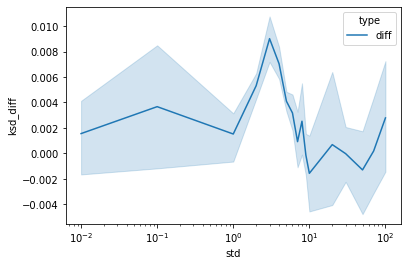

In [17]:
# difference
sns.lineplot(data=diff_ksd_df, x="std", y="ksd_diff", hue="type")
plt.xscale("log")

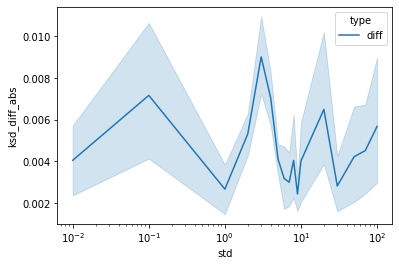

In [18]:
# abs difference
sns.lineplot(data=diff_ksd_df, x="std", y="ksd_diff_abs", hue="type")
plt.xscale("log")

## Std estimate

In [26]:
noptim_steps = 100

optimizer = tf.optimizers.Adam(learning_rate=0.1)

In [27]:
std_est_list = []
for seed in trange(100):
    # convolution sample
    conv_sample_full = convolution.sample(num_est) # for p

    conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
    conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

    # off-target sample
    off_sample = proposal_off.sample(n)

    log_noise_std = tf.Variable(1.)

    ksd.optim(noptim_steps, log_noise_std, off_sample, tf.identity(off_sample), conv_sample_full, conv_sample, optimizer)
    
    std_est_list.append(tf.math.exp(log_noise_std).numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

2021-12-09 09:24:00.305733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [48]:
# std_est_list_orig = std_est_list
var_est_list = [x**2 for x in std_est_list if x <= 100]

In [49]:
np.mean(var_est_list) - 1.96*np.std(var_est_list)/np.sqrt(n), np.mean(var_est_list) + 1.96*np.std(var_est_list)/np.sqrt(n)

(9.135756177888009, 9.708941349638732)

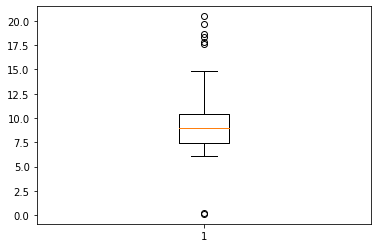

In [54]:
_ = plt.boxplot(var_est_list)

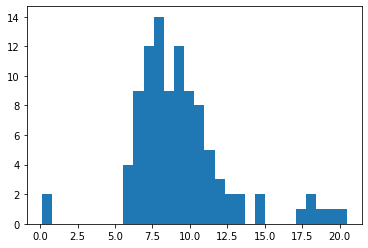

In [53]:
_ = plt.hist(var_est_list, bins=30)

In [61]:
res = pd.read_csv("res/compare_samplers/4.0_optim.csv")

In [79]:
vv = res.loc[(res.type == "off-target") & (res.n == 500)]

In [87]:
vv.ksd.to_numpy() - res.loc[(res.type == "target") & (res.n == 500), "ksd"].to_numpy()

array([-0.00137382, -0.02142556, -0.01472314,  0.00107817, -0.00452128,
       -0.00137245, -0.00258348,  0.00278895, -0.0110436 , -0.00738295])

In [81]:
[x for x in vv.var_est]

[4.894699866680696,
 2.0358307685265257e-06,
 12.384079565996217,
 0.0001498157094,
 6.782292919447684,
 1.3811616051831856e-05,
 8.004496920914846,
 255278.27177478463,
 7.0937639830845,
 1038485.8909621836]

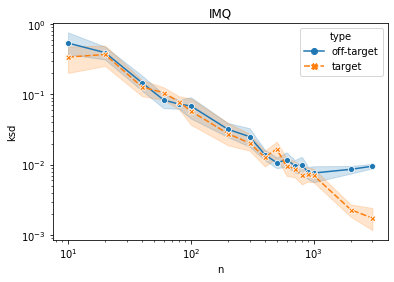

In [91]:
sns.lineplot(data=res, x="n", y="ksd", hue="type", style="type", markers=True)
plt.title("IMQ")
plt.xscale("log")
plt.yscale("log")